<a href="https://colab.research.google.com/github/frankl1/Introduction-to-Tensorflow-for-Deep-Learning/blob/master/exercise_flowers_with_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
try:
  %tensorflow_version 2.x
except:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow import keras
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import logging

TensorFlow 2.x selected.


# Config

In [0]:
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

In [0]:
EPOCH = 6
IMG_SHAPE = 224
BATCH_SIZE = 32

# Dataset

In [4]:
splits = tfds.Split.ALL.subsplit(weighted=[7,3])
flowers_dataset, infos = tfds.load("tf_flowers", as_supervised=True, with_info=True, split=splits)
train_examples, val_examples = flowers_dataset

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/1.0.0. Subsequent calls will reuse this data.


In [5]:
classes = infos.features['label'].names
num_train_example = infos.splits['train'].num_examples
num_train_example

3670

In [6]:
infos

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=1.0.0,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [0]:
def plot_samples(samples, n_sample=10):
  n_rows = np.ceil(np.sqrt(n_sample))
  n_cols = n_rows
  plt.figure(figsize=(8, 8))
  for i in range(n_sample):
    sample_img, sample_label = samples[i]
    sample_img = sample_img.numpy()
    sample_label = sample_label.numpy()
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(sample_img)
    plt.axis('off')
    plt.title(classes[sample_label])
    plt.xlabel("shape=" + str(sample_img.shape))
    plt.tight_layout()

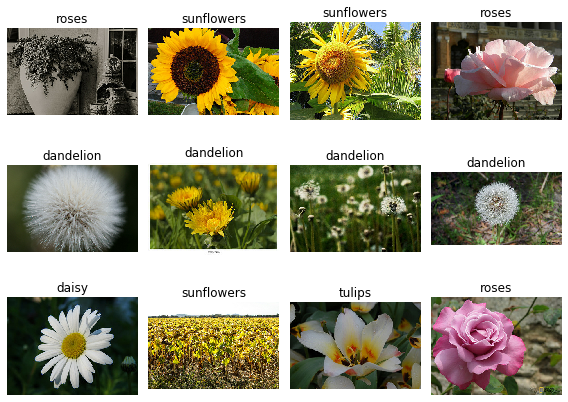

In [63]:
samples = [(img, label) for img, label in iter(train_examples.take(12))]
plot_samples(samples, 12)

In [0]:
def format(image, label):
  image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE)) / 255
  return image, label

In [0]:
train_data = train_examples.shuffle(num_train_example).map(format).batch(BATCH_SIZE).prefetch(1)
val_data = val_examples.map(format).batch(BATCH_SIZE).prefetch(1)

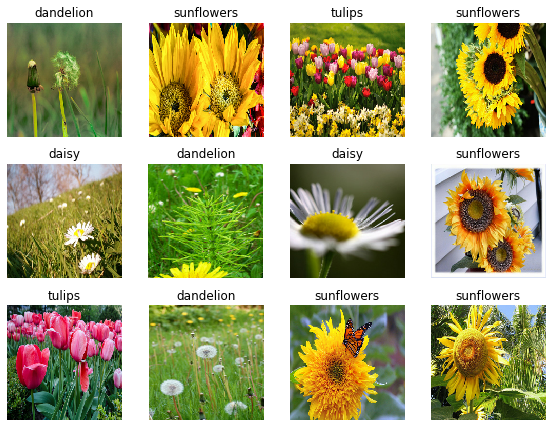

In [60]:
samples, labels = next(iter(train_data.take(1)))
samples = [(img, label) for img, label in zip(samples, labels)]
plot_samples(samples, 12)

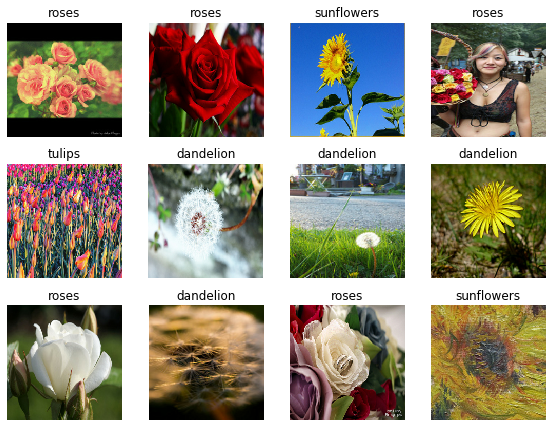

In [61]:
samples, labels = next(iter(val_data.take(1)))
samples = [(img, label) for img, label in zip(samples, labels)]
plot_samples(samples, 12)

# The model

In [0]:
mobile_net_feature_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
model = keras.Sequential([
  hub.KerasLayer(mobile_net_feature_url, trainable=False),
  keras.layers.Dense(len(classes), activation="softmax")
])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [22]:
history = model.fit(train_data, validation_data=val_data, epochs=EPOCH)

Epoch 1/10
81/81 [==============================] - 12s 147ms/step - loss: 0.7550 - accuracy: 0.7197 - val_loss: 0.5078 - val_accuracy: 0.8269
Epoch 2/10
81/81 [==============================] - 9s 106ms/step - loss: 0.3531 - accuracy: 0.8842 - val_loss: 0.4150 - val_accuracy: 0.8620
Epoch 3/10
81/81 [==============================] - 9s 108ms/step - loss: 0.2799 - accuracy: 0.9089 - val_loss: 0.3853 - val_accuracy: 0.8713
Epoch 4/10
81/81 [==============================] - 9s 108ms/step - loss: 0.2305 - accuracy: 0.9290 - val_loss: 0.3580 - val_accuracy: 0.8769
Epoch 5/10
81/81 [==============================] - 9s 107ms/step - loss: 0.1938 - accuracy: 0.9475 - val_loss: 0.3546 - val_accuracy: 0.8815
Epoch 6/10
81/81 [==============================] - 9s 106ms/step - loss: 0.1721 - accuracy: 0.9525 - val_loss: 0.3437 - val_accuracy: 0.8796
Epoch 7/10
81/81 [==============================] - 8s 99ms/step - loss: 0.1491 - accuracy: 0.9610 - val_loss: 0.3405 - val_accuracy: 0.8824
Epoch 

In [0]:
def plot_history(history):
  plt.figure(figsize=(8, 5))
  plt.subplot(1, 2, 1)
  plt.plot(history["accuracy"], label="Train accuracy")
  plt.plot(history["val_accuracy"], label="Val accuracy")
  plt.title("Accuracy")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history["loss"], label="Train loss")
  plt.plot(history["val_loss"], label="Val loss")
  plt.title("Loss")
  plt.legend()

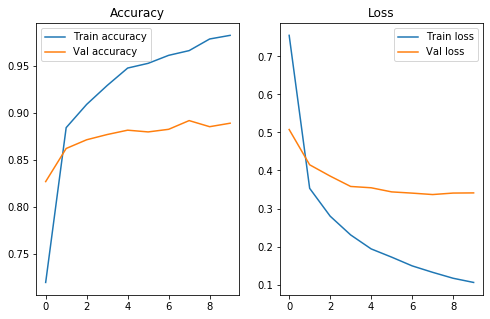

In [24]:
plot_history(history.history)

# Some predictions

In [0]:
samples, labels = next(iter(val_data.take(1)))
predictions = model.predict(samples)
predictions = predictions.argmax(axis=1)

In [0]:
def plot_predictions(samples, t_labels, p_labels, n_samples=10):
  n_rows = np.ceil(np.sqrt(n_samples))
  n_cols = n_rows
  plt.figure(figsize=(8, 8))
  for i, (img, t_label, p_label) in enumerate(zip(samples[:n_samples], t_labels[:n_samples], p_labels[:n_samples])):
    plt.subplot(n_rows, n_cols, i+1)
    plt.title(classes[t_label])
    color = "green" if t_label == p_label else "red"
    plt.xlabel(classes[p_label], color=color)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

  plt.tight_layout()

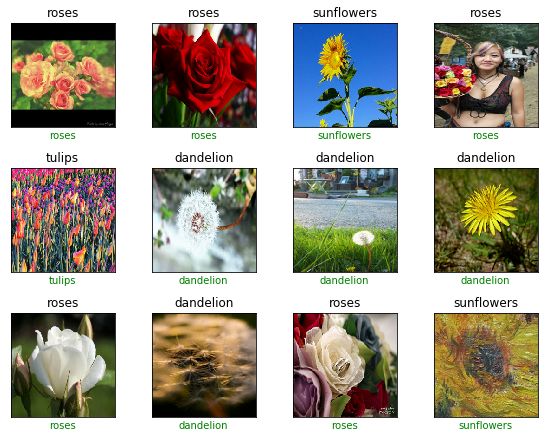

In [71]:
plot_predictions(samples, labels, predictions, 12)

# Transfer Learning with the Inception model

In [0]:
IMG_SHAPE_INCEP = 299

In [0]:
def format_for_inception(image, label):
  image = tf.image.resize(image, (IMG_SHAPE_INCEP, IMG_SHAPE_INCEP)) / 255
  return image, label

In [0]:
train_data = train_examples.shuffle(num_train_example).map(format_for_inception).batch(BATCH_SIZE).prefetch(1)
val_data = val_examples.map(format_for_inception).batch(BATCH_SIZE).prefetch(1)

In [96]:
inception_feature_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
inception_model = keras.Sequential([
  hub.KerasLayer(inception_feature_url, trainable=False, input_shape=(IMG_SHAPE_INCEP, IMG_SHAPE_INCEP, 3)),
  keras.layers.Dense(len(classes), activation="softmax")
])
inception_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_12 (KerasLayer)  (None, 2048)              21802784  
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


Epoch 1/6
81/81 [==============================] - 24s 292ms/step - loss: 0.7379 - accuracy: 0.7432 - val_loss: 0.5105 - val_accuracy: 0.8176
Epoch 2/6
81/81 [==============================] - 18s 216ms/step - loss: 0.3793 - accuracy: 0.8792 - val_loss: 0.4007 - val_accuracy: 0.8657
Epoch 3/6
81/81 [==============================] - 18s 226ms/step - loss: 0.2937 - accuracy: 0.9127 - val_loss: 0.3652 - val_accuracy: 0.8750
Epoch 4/6
81/81 [==============================] - 17s 214ms/step - loss: 0.2530 - accuracy: 0.9216 - val_loss: 0.3383 - val_accuracy: 0.8796
Epoch 5/6
81/81 [==============================] - 17s 214ms/step - loss: 0.2164 - accuracy: 0.9363 - val_loss: 0.3285 - val_accuracy: 0.8870
Epoch 6/6
81/81 [==============================] - 18s 220ms/step - loss: 0.1969 - accuracy: 0.9436 - val_loss: 0.3215 - val_accuracy: 0.8944


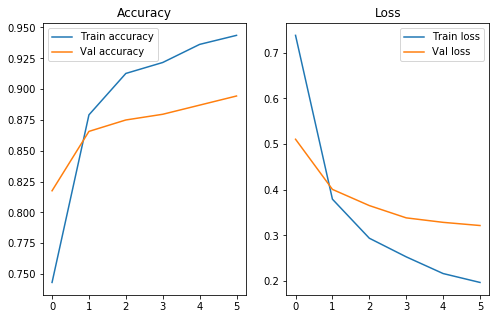

In [97]:
inception_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

history = inception_model.fit(train_data, validation_data=val_data, epochs=EPOCH)

plot_history(history.history)

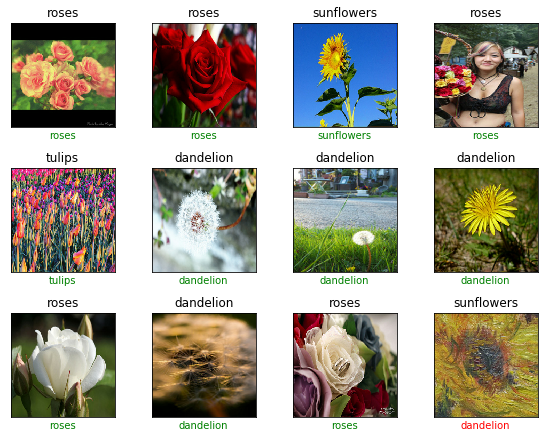

In [98]:
samples, labels = next(iter(val_data.take(1)))
predictions = inception_model.predict(samples)
predictions = predictions.argmax(axis=1)

plot_predictions(samples, labels, predictions, 12)